In [1]:
import sys
sys.path.append('..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.GeneticAlgorithm import GeneticAlgorithm
import random as rnd

In [2]:
path = "datasets/flowers"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

datasets/flowers/daisy
datasets/flowers/dandelion
datasets/flowers/rose
datasets/flowers/sunflower
datasets/flowers/tulip


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:

X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train[2].shape

(224, 224, 3)

In [ ]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(3021, 224, 224, 3) Y_train:(3021,) X_test:(1296, 224, 224, 3) Y_test:(1296,)


In [ ]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
evaluations=0

for train_index, test_index in kf.split(X_test):
    m= keras.models.clone_model(model)
    
    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

5/5 [==============================] - 0s 14ms/step - loss: 1.4020 - accuracy: 0.4729
0.34648181647062304


In [ ]:
ga=GeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [ ]:
best_solution= ga.run(generation_limit=15, population_size=20)

--------------------------------------------------------------------------------
10/10 [==============================] - 0s 16ms/step - loss: 1.3225 - accuracy: 0.4636
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.4683998912572861
--------------------------------------------------------------------------------
10/10 [==============================] - 0s 16ms/step - loss: 1.7076 - accuracy: 0.2682
filter [29, 126, 63, 181, 4, 246, 187, 181, 122, 151, 19, 0, 5, 133, 77, 0] fit: 0.3419076383113861
--------------------------------------------------------------------------------
10/10 [==============================] - 0s 17ms/step - loss: 1.3985 - accuracy: 0.3411
filter [14, 130, 79, 210, 67, 180, 7, 94, 190, 97, 19, 1, 5, 140, 401, 0] fit: 0.38961379826068876
--------------------------------------------------------------------------------
10/10 [==============================] - 0s 16ms/step - loss: 1.5716 - accuracy: 0.2781
filter [18, 142, 8, 240, 63, 127, 5

In [ ]:
print(f"\nbest filter :{best_solution.filter} fit: {best_solution.fit}")


best filter :[0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.4683998912572861


In [ ]:
new_X_test=np.array(ga.get_newData(X_test,best_solution.filter))

new_X_test.shape

(1296, 224, 224, 3)

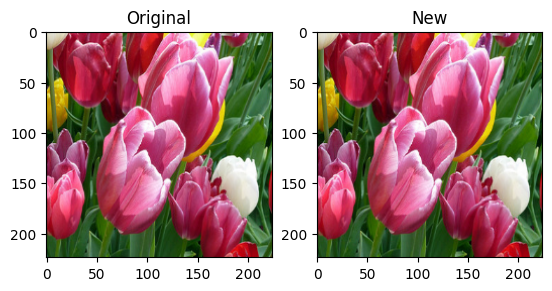

In [ ]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(new_X_test[index])
ax2.set_title('New')

plt.show()

In [ ]:
evaluations=0

for train_index, test_index in kf.split(new_X_test):
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(new_X_test)[train_index], np.array(new_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]
    del m
    gc.collect()
print(evaluations/10)

5/5 [==============================] - 0s 14ms/step - loss: 1.6066 - accuracy: 0.2171
0.3401729315519333
